<a href="https://www.kaggle.com/code/vladosht/s-p-500-fundamental-data-model?scriptVersionId=267320293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook will present a model which fits the S&P 500 index to the fundamental financial data of the public companies, which report to the SEC. If the model makes sense, it can be assumed that the data in the used datasets is generally consistent.  
  
DISCLAIMER: The results of this model must not in any way be interpreted as financial advice. It is intended for research purposes only and no investment decisions must be taken based on it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics
# Workaround for a pandas bug, as described here:
# https://stackoverflow.com/questions/30519487/pandas-error-invalid-value-encountered
pd.set_option('display.float_format', lambda x:'%f'%x)

In [2]:
#The features, which are directly dependent on the Revenues, will have special treatment later on.
ml_revenue_derived_features = ['NetCashOperating_ttm','Revenue_ttm','GrossProfit_ttm']
ml_features = ['Assets','Liabilities'] + ml_revenue_derived_features #These fundamentals will be the input of the model
ml_label = 'SNP500'
window_size = 12*3 #in snapshots

In [3]:
# Load the S&P 500 data
sp500 = pd.read_csv('/kaggle/input/s-and-p-500-gspc-historical-data/sap500.csv')
sp500['snapshot'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.sort_values(by='snapshot').set_index('snapshot')
sp500 = sp500.drop(columns=[i for i in sp500.columns if i != 'Close']).rename(columns={'Close':ml_label})
sp500

,SNP500
snapshot,
1927-12-30,17.660000
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000
...,...
2025-10-03,6715.790039
2025-10-06,6740.279785
2025-10-07,6714.589844


In [4]:
# Load the fundamental data sourced from the SEC
keys = ['snapshot','cik','date']
snapshots = pd.read_csv('/kaggle/input/fundamental-data-from-sec-xbrl-companyfacts-zip/snapshots.csv', dtype={'cik':str})
for i in ['snapshot','date']: #The key date and the corresponding latest period-end date. 
    snapshots[i] = pd.to_datetime(snapshots[i]).dt.date
    
# The key date must always be later than the period-end date
# We also ensure a window_size number of snapshots of historic data is available for each cik.
# This new column will help us enforce these rules
snapshots['timediff'] = pd.to_timedelta((snapshots['snapshot'] - snapshots['date'])).dt.days
valid_ciks = snapshots.groupby(by='cik')['timediff'].aggregate(['min','count'])
valid_ciks = valid_ciks[(valid_ciks['min']>0)&(valid_ciks['count']>window_size)]
snapshots = snapshots.sort_values(by=keys).set_index(keys)
snapshots = snapshots.loc[(slice(None),valid_ciks.index.to_list()),:].sort_index()
snapshots

Assets  Revenue     COGS  GrossProfit  \
snapshot   cik        date                                                  
2012-01-01 0000001750 2011-11-30  1.821612 0.482000 0.403400     0.078600   
           0000001800 2011-09-30 59.628176 9.816682 3.973250     5.843432   
           0000001961 2011-09-30       NaN 0.000000 0.000000     0.000000   
           0000002034 2011-09-30  0.292355 0.101317 0.082798     0.018519   
           0000002098 2011-09-30  0.055344 0.019036 0.012396     0.006640   
...                                    ...      ...      ...          ...   
2025-10-04 0001918080 2025-06-30  0.000009      NaN      NaN          NaN   
           0001918102 2025-06-30  0.000011      NaN      NaN          NaN   
           0001922639 2025-06-30  0.012915 0.000113      NaN          NaN   
           0001930313 2025-06-30  0.315299 0.043359 0.013348     0.030011   
           0001933359 2025-07-31  0.000021 0.000013      NaN          NaN   

                                    Equity  NetCashOperating  \
snapshot   cik        date                                     
2012-01-01 0000001750 2011-11-30  0.863948          0.030412   
           0000001800 2011-09-30 24.603800          3.054430   
           0000001961 2011-09-30       NaN         -0.000067   
           0000002034 2011-09-30  0.161372          0.005913   
           0000002098 2011-09-30  0.027561          0.003165   
...                                    ...               ...   
2025-10-04 0001918080 2025-06-30 -0.000175         -0.000017   
           0001918102 2025-06-30 -0.000178         -0.000017   
           0001922639 2025-06-30  0.001930         -0.000170   
           0001930313 2025-06-30  0.244592         -0.008340   
           0001933359 2025-07-31 -0.000062         -0.000003   

                                  NetCashFinancing  Earnings   Shares  \
snapshot   cik        date                                              
2012-01-01 0000001750 2011-11-30         -0.006559  0.017600 0.040283   
           0000001800 2011-09-30         -2.668122  0.303181 1.557796   
           0000001961 2011-09-30          0.000150 -0.000147 0.073429   
           0000002034 2011-09-30         -0.001570  0.003033 0.026730   
           0000002098 2011-09-30         -0.000680  0.000682 0.003128   
...                                            ...       ...      ...   
2025-10-04 0001918080 2025-06-30          0.000022 -0.000013 0.005000   
           0001918102 2025-06-30          0.000025 -0.000013 0.005000   
           0001922639 2025-06-30          0.002000 -0.000961 0.000552   
           0001930313 2025-06-30          0.007182  0.002458 0.103881   
           0001933359 2025-07-31          0.000000 -0.000004 0.005495   

                                  Liabilities  Revenue_ttm  GrossProfit_ttm  \
snapshot   cik        date                                                    
2012-01-01 0000001750 2011-11-30     0.957664     1.920517         0.322328   
           0000001800 2011-09-30    35.024376    38.441677        22.693948   
           0000001961 2011-09-30          NaN     0.000188         0.000169   
           0000002034 2011-09-30     0.130983          NaN              NaN   
           0000002098 2011-09-30     0.027783     0.093494         0.033742   
...                                       ...          ...              ...   
2025-10-04 0001918080 2025-06-30     0.000184          NaN              NaN   
           0001918102 2025-06-30     0.000189          NaN              NaN   
           0001922639 2025-06-30     0.010985     0.000543              NaN   
           0001930313 2025-06-30     0.070707     0.188193         0.144855   
           0001933359 2025-07-31     0.000082     0.000029              NaN   

                                  NetCashOperating_ttm  NetCashFinancing_ttm  \
snapshot   cik        date                                                     
2012-01-01 0000001750 2011-11-30              0.083588         

We need aggregation across the entire market. Because of the varying record counts of the different features, it seems it is best to use the mean.

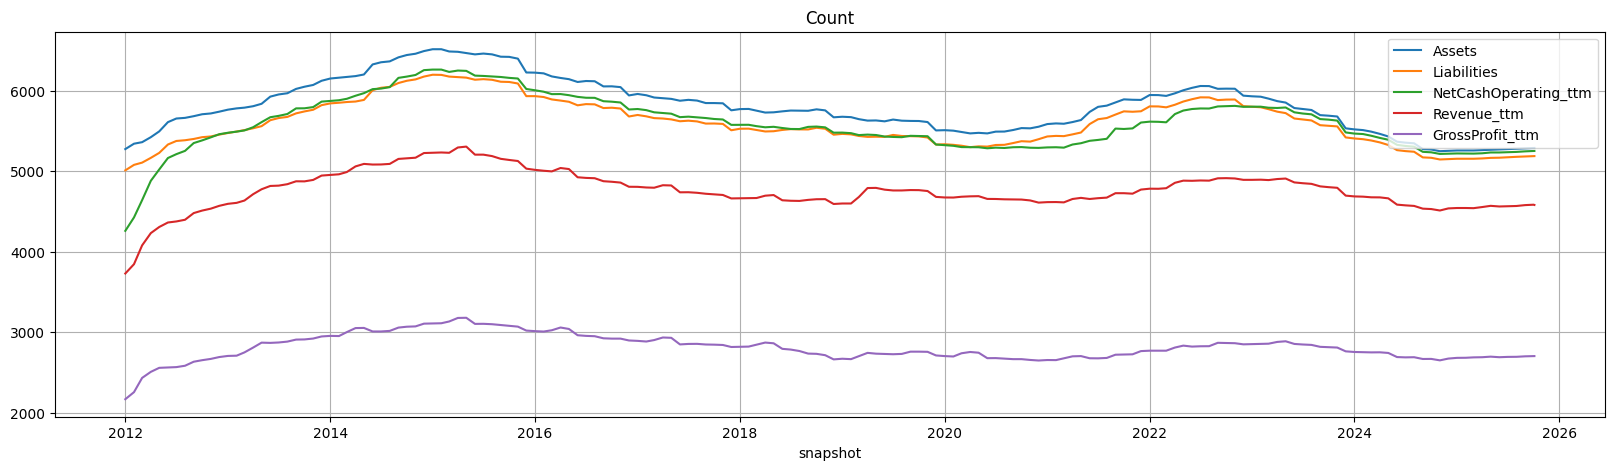

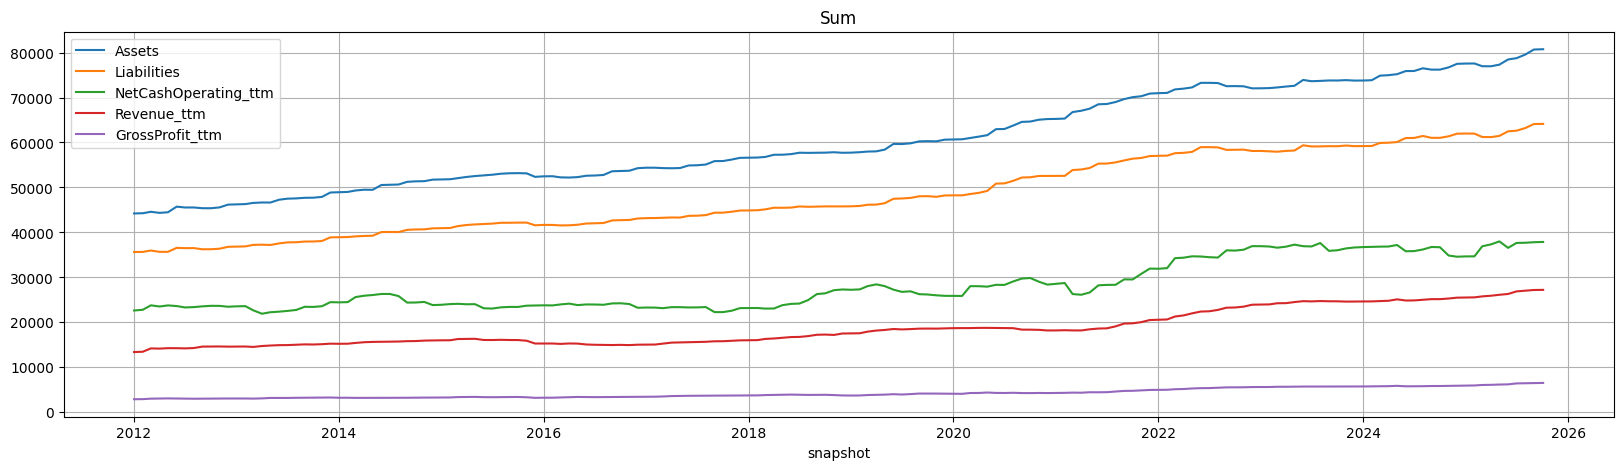

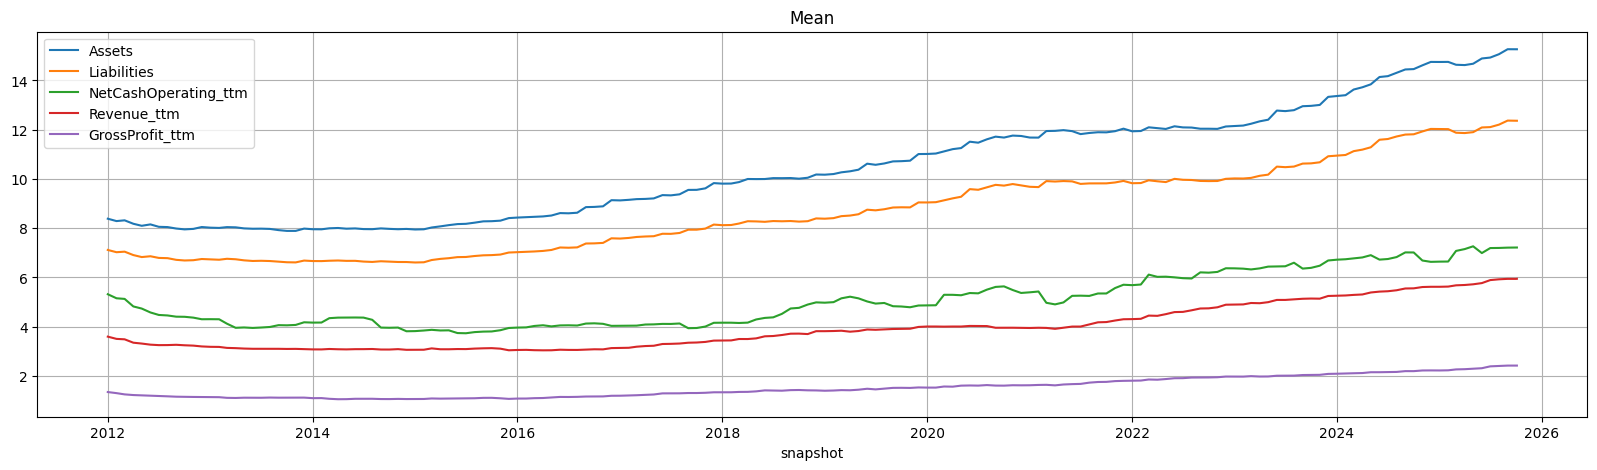

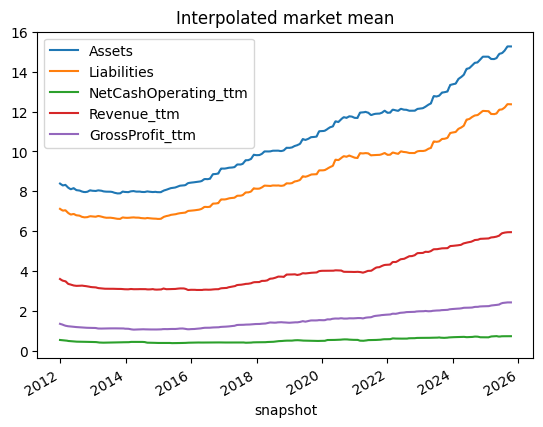

,Assets,Liabilities,NetCashOperating_ttm,Revenue_ttm,GrossProfit_ttm,SNP500
snapshot,,,,,,
2012-01-01,8.384633,7.115258,0.531631,3.593632,1.342736,1267.330017
2012-01-03,8.380043,7.110898,0.530851,3.589296,1.340628,1277.060059
2012-01-04,8.375452,7.106539,0.530071,3.584960,1.338520,1277.300049
2012-01-05,8.370861,7.102180,0.529290,3.580624,1.336412,1281.060059
2012-01-06,8.366270,7.097820,0.528510,3.576288,1.334304,1277.810059
...,...,...,...,...,...,...
2025-10-04,15.268550,12.364419,0.721462,5.944515,2.417922,6728.034912
2025-10-06,15.268550,12.364419,0.721462,5.944515,2.417922,6740.279785
2025-10-07,15.268550,12.364419,0.721462,5.944515,2.417922,6714.589844


In [5]:
market = snapshots.copy()
market['NetCashOperating_ttm'] *= 10 #This is done for clarity. We reverse it a few lines below
market = market.groupby(by='snapshot')[ml_features]
market.count().plot(grid=True,figsize=(20,5),title='Count')
market.sum().plot(grid=True,figsize=(20,5),title='Sum')
market.mean().plot(grid=True,figsize=(20,5),title='Mean')
market = market.mean()
market['NetCashOperating_ttm'] /= 10
market = pd.merge(market,sp500,left_index=True,right_index=True,how='outer').interpolate().dropna()
market[ml_features].plot(title='Interpolated market mean')
plt.show()
market

Because of the concept of "phony assets" one could assume the market adjusts the total assets away from their nominal value. When we test this with an ensemble of outlier-resistent linear regression models, this seems to not be the case:

In [6]:
def create_model(dummy):
    exploration_model = linear_model.TheilSenRegressor(n_jobs=-1).fit(X=market[ml_features],y=market[ml_label])
    exploration_coefs = pd.Series(data = exploration_model.coef_.tolist(), index=ml_features).to_frame().T
    return exploration_coefs
exploration_models = pd.concat(list(map(create_model,range(50))),axis='index').reset_index(drop=True)
exploration_results = exploration_models.divide(-1*exploration_models['Liabilities'],axis='index')
exploration_results = exploration_results.describe()
exploration_results = pd.concat([exploration_results,(exploration_results.loc['std']/exploration_results.loc['mean']).to_frame().rename(columns={0:'rel_std'}).T])
exploration_results

,Assets,Liabilities,NetCashOperating_ttm,Revenue_ttm,GrossProfit_ttm
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.992358,-1.000000,-0.335838,-0.105300,0.444622
std,0.012642,0.000000,0.078668,0.017590,0.052281
min,0.963153,-1.000000,-0.530250,-0.137039,0.360295
25%,0.983893,-1.000000,-0.383870,-0.118510,0.411411
50%,0.991282,-1.000000,-0.315408,-0.103035,0.444498
75%,1.000937,-1.000000,-0.283079,-0.094122,0.469656
max,1.024565,-1.000000,-0.165126,-0.064541,0.598493
rel_std,0.012740,-0.000000,-0.234244,-0.167042,0.117585


We see that both the mean and the median of the assets coefficient are very close to 1 with only about 1% of relative standard deviation. This effectively means, that the market uses the Equity or the book value, as it appears on the balance sheet and does not adjust anything. So, we create our final model using Equity as-is.

In [7]:
model_features = market[ml_features].copy()
model_features['Equity'] = model_features['Assets'] - model_features['Liabilities']
model_features = model_features[['Equity']+ml_revenue_derived_features]
model_features

,Equity,NetCashOperating_ttm,Revenue_ttm,GrossProfit_ttm
snapshot,,,,
2012-01-01,1.269376,0.531631,3.593632,1.342736
2012-01-03,1.269144,0.530851,3.589296,1.340628
2012-01-04,1.268913,0.530071,3.584960,1.338520
2012-01-05,1.268681,0.529290,3.580624,1.336412
2012-01-06,1.268450,0.528510,3.576288,1.334304
...,...,...,...,...
2025-10-04,2.904131,0.721462,5.944515,2.417922
2025-10-06,2.904131,0.721462,5.944515,2.417922
2025-10-07,2.904131,0.721462,5.944515,2.417922


In [8]:
model = linear_model.TheilSenRegressor(n_jobs=-1,n_subsamples=len(model_features)//500).fit(X=model_features,y=market[ml_label])
coefs = pd.Series(data = model.coef_.tolist(), index=model_features.columns)
slope = coefs['Equity']
coefs /= slope
coefs = coefs.to_frame().T
coefs

,Equity,NetCashOperating_ttm,Revenue_ttm,GrossProfit_ttm
0,1.000000,-0.788846,-0.045016,0.442104


In [9]:
# Here we spell out the model explicitly
def compose_model_formula():
    model_formula = f"S&P500 = {round(slope,2)} * ("
    for col in coefs.columns:
        val = coefs.loc[0,col].round(2)
        model_formula += f"{' ' if val < 0 else ' +'}{val}*{col}"
    val = round(model.intercept_,2)
    model_formula += f"){' ' if val < 0 else ' +'}{val}"
    return model_formula
print(compose_model_formula())

S&P500 = 2426.93 * ( +1.0*Equity -0.79*NetCashOperating_ttm -0.05*Revenue_ttm +0.44*GrossProfit_ttm) -1546.36


It is interesting to see the total effect of the revenue-derived features. It seems to be always positive:

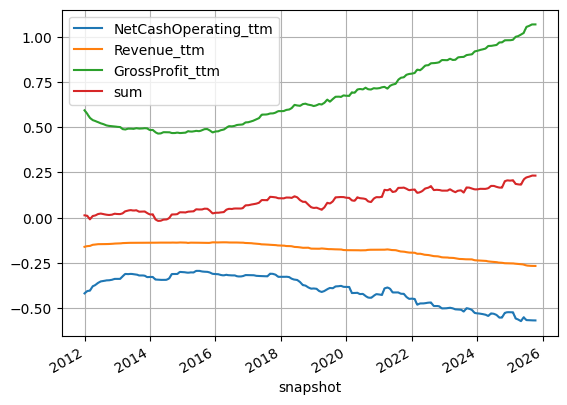

In [10]:
revenue_derived = market[ml_revenue_derived_features]*coefs[ml_revenue_derived_features].loc[0]
revenue_derived['sum'] = revenue_derived.sum(axis='columns')
revenue_derived.plot(grid=True)
plt.show()

As we use an outlier-resistent linear regression for our model, it deviates from the linear regression, which minimizes the mean square error (the 're-fit' column):

R-squared:
          model   SNP500   re-fit
model  1.000000 0.961710 1.000000
SNP500 0.961710 1.000000 0.961710
re-fit 1.000000 0.961710 1.000000
Residual slope: a=[1.0498137], b=-114.08491991682513


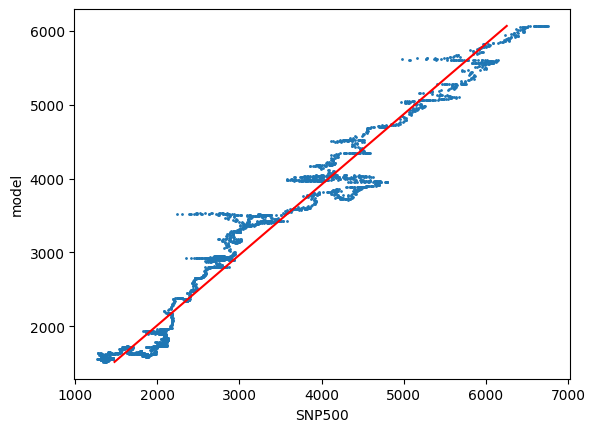

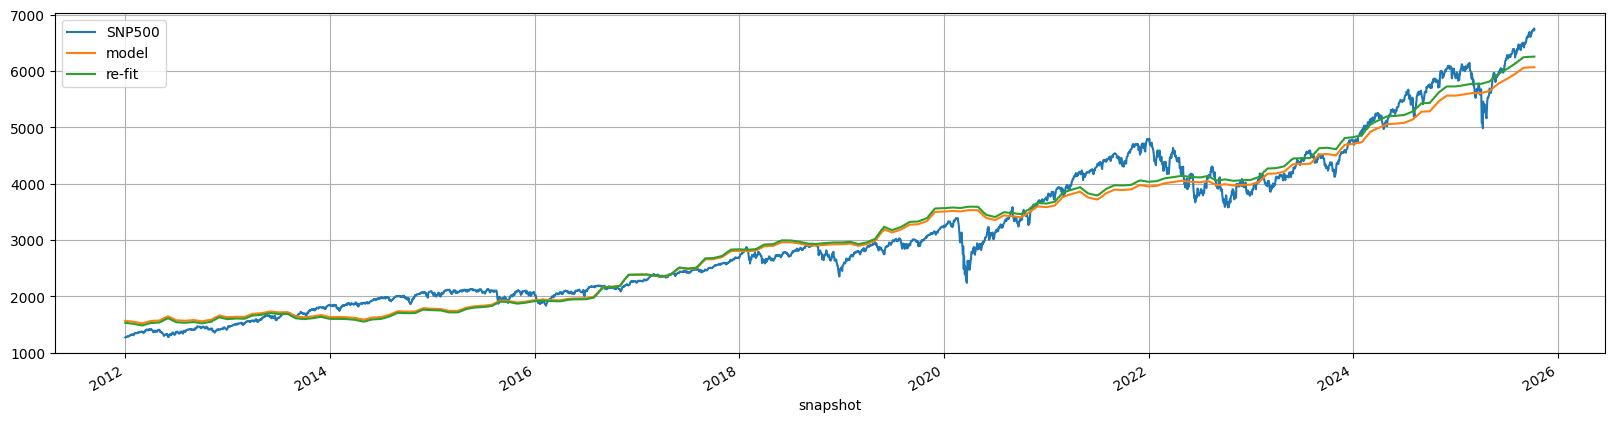

,Assets,Liabilities,NetCashOperating_ttm,Revenue_ttm,GrossProfit_ttm,SNP500,Equity,model,re-fit
snapshot,,,,,,,,,
2025-10-06,15.268550,12.364419,0.721462,5.944515,2.417922,6740.279785,2.904131,6065.415417,6253.471257
2025-10-07,15.268550,12.364419,0.721462,5.944515,2.417922,6714.589844,2.904131,6065.415417,6253.471257
2025-10-08,15.268550,12.364419,0.721462,5.944515,2.417922,6753.720215,2.904131,6065.415417,6253.471257
2025-10-09,15.268550,12.364419,0.721462,5.944515,2.417922,6735.109863,2.904131,6065.415417,6253.471257


In [11]:
def plot_fit(p_df):
    regressor_data = p_df[['model',ml_label]].copy()

    regressor = linear_model.LinearRegression().fit(X=regressor_data[['model']],y=regressor_data[ml_label])
    regressor_data['re-fit'] = regressor.predict(regressor_data[['model']])

    print('R-squared:')
    print(regressor_data.corr()**2)
    print(f"Residual slope: a={regressor.coef_}, b={regressor.intercept_}")

    regressor_data.plot.scatter(x=ml_label,y='model',s=1)
    regressor_x = np.linspace(regressor_data['model'].min(),regressor_data['model'].max(),100) 
    plt.plot(regressor.predict(pd.DataFrame(pd.Series(regressor_x).rename('model'))),regressor_x,c='r')
    plt.show()
   
    regressor_data[[ml_label,'model','re-fit']].plot(grid=True,figsize=(20,5),legend=True)
    plt.show()

    p_df['re-fit'] = regressor_data['re-fit']
    return p_df

result = market.copy()
result['Equity'] = model_features['Equity']
result['model'] = model.predict(result[model_features.columns])
result = plot_fit(result)
result.tail(4)

Some other metrics, which show the difference between the two types of linear regression:

In [12]:
final_models = ['model','re-fit']
#The Explained Variance score is similar to the R^2 score, with the notable difference
#that it does not account for systematic offsets in the prediction.
loss_data = list()
for a_metric in [metrics.mean_squared_error, metrics.explained_variance_score, metrics.mean_absolute_percentage_error]:
    loss_data.append([a_metric(result[ml_label],result[i]) for i in final_models])
pd.DataFrame(data=loss_data,columns=final_models,index=['Mean Squared Error','Explained Variance','Mean Abs. Percent Error'])

,model,re-fit
Mean Squared Error,77164.437066,71511.857940
Explained Variance,0.959544,0.961710
Mean Abs. Percent Error,0.076236,0.076737


We can divide the index values by the model values and see the median and mean of these ratios. Once again, both are very close to 1, which indicates the model behaves very similarly to the actual index.

In [13]:
percentiles = (result[ml_label]/result['model']).describe(percentiles=[i/10 for i in range(1,10)])
print(int(percentiles['count']),"snapshots")
percentiles = percentiles.drop(index=['count'])
percentiles

3524 snapshots


mean   1.010624
std    0.094663
min    0.635236
10%    0.900517
20%    0.931407
30%    0.953806
40%    0.977632
50%    0.999004
60%    1.030541
70%    1.064211
80%    1.092670
90%    1.152547
max    1.216196
dtype: float64

The above percentiles can tell us where the current index value stands, compared to the historic fundamentals.

In [14]:
# Multiply the percentiles by the latest model value
percentiles *= result.loc[result.tail(1).index[0]]['model']
percentiles['relative_std'] = percentiles['std'] / percentiles['mean']
percentiles

mean           6129.854948
std             574.170479
min            3852.970203
10%            5462.007095
20%            5649.373001
30%            5785.231258
40%            5929.743092
50%            6059.372917
60%            6250.659472
70%            6454.884802
80%            6627.495344
90%            6990.677742
max            7376.734922
relative_std      0.093668
dtype: float64

We can use the same approach to create a historic graph showing how the index values compared to the fundamentals since 2012:

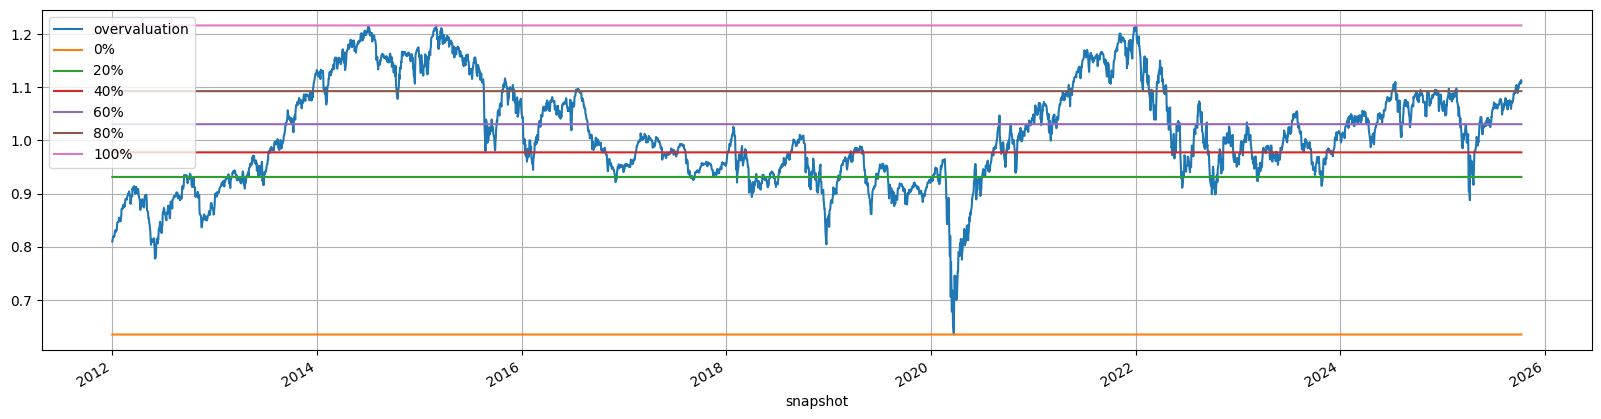

In [15]:
percentile_graph = (result[ml_label]/result['model'])
percentile_graph.name = 'overvaluation'
percentile_graph = percentile_graph.to_frame()
max_percentiles = 5
for i in range(max_percentiles+1):
    i /= max_percentiles
    percentile_graph[f"{100*i:.0f}%"] = percentile_graph['overvaluation'].quantile(q=i)
percentile_graph.plot(legend=True,figsize=(20,5),grid=True).legend(loc="upper left")
plt.show()

In [16]:
print('Done without errors.')

Done without errors.
